<a href="https://colab.research.google.com/github/sanzianamaieczki/LICENTA---clinica-medicala/blob/main/p4_w1_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 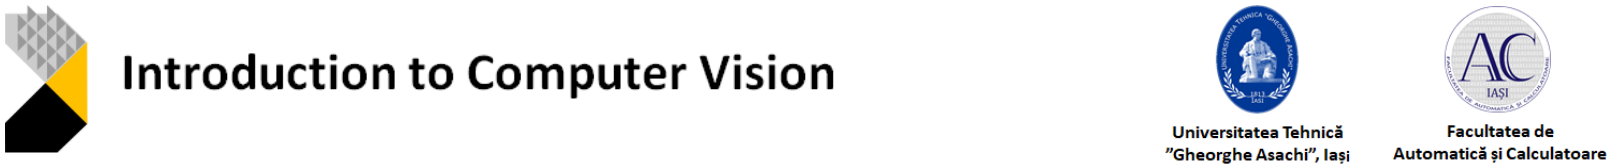

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs.
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 4: Obstacles detection based on disparity maps

## Week 1: Depth estimation and 3D reconstruction based on disparity maps

**Stereo Vision**

Before getting into details let's test our stereo vision - try  [The Eye Hop](https://www.vision3d.com/ehop.html) and [The Framing Game](https://www.vision3d.com/frame.html)


<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1ZdNCG4ScJ8QTU2x_8ak0VCWZV-JWpjzm' />
<figcaption>Stereo vision: the object P is observed from two cameras. The object's position is different in both images.
</figcaption></center>
</figure>



### Disparity computation (stereo matching)

In [10]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

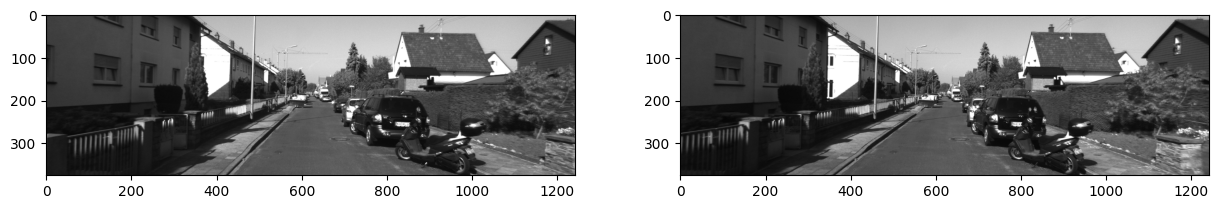

In [12]:
#TO DO:
#(1) load the stereo images provided and compute the disparity map using: (I) the Block-Matching algorithm, (II) the Semi-Global Block Matching algorithm
#(2) load the precomputed disparity maps and compare the three results
# https://drive.google.com/drive/folders/1q59CF5S0zKB5jPv9L8An-hrQur9OHKc7?usp=sharing
#load left and right image
dataset_path = '/content/drive/MyDrive/SVA/P4'
left_img = cv2.imread(dataset_path + '/left/000005.png', cv2.IMREAD_COLOR)
right_img = cv2.imread(dataset_path + '/right/000005.png', cv2.IMREAD_COLOR)

#display left and right image

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_img)
plt.subplot(1, 2, 2)
plt.imshow(right_img)
plt.show()

**The Block-Matching algorithm**

Estimates disparity at a point by comparing a small
region about that point with congruent regions
extracted from the other image

Three classes of metrics used for the comparison:
*   Correlation (NCC - normalized Cross Correlation)
*   Intensity difference (SAD - Sum of Absolute Differences, SSD - Sum of Squared Differences)
*   Rank (rank transform, census transform)

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1R4z_VFQQeoVjPBXoqQSKRpo-O5J7mY9r' />
<figcaption>Slide a window along the epipolar line and compare contents of that window with the refence window in the lef image.</figcaption></center>
</figure>


<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=194nLEeE-69RNIqfIOyxCUohIY1jB9Z4H' />
<figcaption>Results using different metrics</figcaption></center>
</figure>


**The effect of window size**

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1zlKsLhCaTsq61Npba537DoP99fsQQLqq' />
<figcaption></figcaption></center>
</figure>

*   smaller window: more detail(+), more noise(-)
*   larger windows: smooter disparity maps(+), less detail(-), fails near boundaries(-)

Generally, stereo block matching will fail for *textureless regions*, *repeated patterns* and *specularities*.



In [13]:
def blockMatching(left, right, window_size):
  #convert color images to grayscale images
  left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
  right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

  #apply the Block-Matching algorithm

  stereo = cv2.StereoBM_create(numDisparities=64, blockSize=window_size)
  disparity = stereo.compute(left_gray, right_gray)
  dispmap = cv2.convertScaleAbs(disparity)

  return dispmap

**The Semi-Global Block Matching algorithm**

Semi-global matching uses information from neighboring pixels in multiple directions to calculate the disparity of a pixel. Analysis in multiple directions results in a lot of computation. Instead of using the whole image, the disparity of a pixel can be calculated by considering a smaller block of pixels for ease of computation. Thus, the Semi-Global Block Matching (SGBM) algorithm uses block-based cost matching that is smoothed by path-wise information from multiple directions.
Using the block-based approach, this algorithm estimates an approximate disparity of a pixel in the left image from the same pixel in the right image.


In [14]:
def sgBlockMatching(left, right, block_size):
  #apply the Semi-Global Block Matching algorithm
  stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=64, blockSize=block_size)
  disparity = stereo.compute(left, right)
  dispmap = cv2.convertScaleAbs(disparity)

  return dispmap

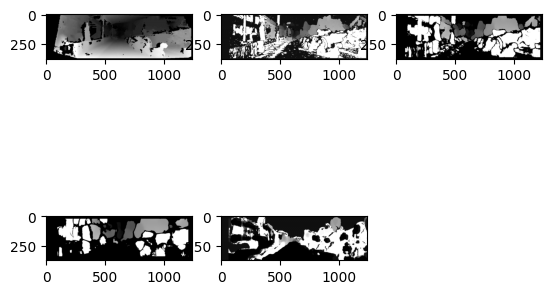

In [22]:
#TO DO:
#(1)compute disparity maps using the Block-Matching and Semi-Global Block Matching algorithms
#(2)load the precomputed disparity maps and compare the three results
#(3)change the window size and compare the results (e.g., w = 32, w = 64)

precomputed_disp = cv2.imread(dataset_path + "/disparity/15_000005_disp.png", cv2.IMREAD_GRAYSCALE)
window_sizes = [15, 31, 63]

plt.subplot(2, 3, 1)
plt.imshow(precomputed_disp, cmap='gray')

for i, w in enumerate(window_sizes):
    disp_bm = blockMatching(left_img, right_img, w)
    disp_sgbm = sgBlockMatching(left_img, right_img, w)

    plt.subplot(2, 3, i + 2)
    plt.imshow(disp_bm, cmap='gray')

    plt.subplot(2, 3, i + 3)
    plt.imshow(disp_sgbm, cmap='gray')

plt.show()


### Depth from disparity

We saw that if we have two images of same scene, we can get depth information from that in an intuitive way. Below is an image and some simple mathematical formulas which proves that intuition.
<figure>
<center>
<img src='https://docs.opencv.org/3.1.0/stereo_depth.jpg' />
</center>
</figure>

The above diagram contains equivalent triangles. Writing their equivalent equations will yield us following result:

$$disparity=x−x′=\frac{Bf}{Z}$$
$x$ and $x′$ are the distance between points in image plane corresponding to the scene point 3D and their camera center. $B$ is the distance between two cameras (which we know) and $f$ is the focal length of camera (already known). So in short, above equation says that the $depth$ of a point in a scene is inversely proportional to the difference in distance of corresponding image points and their camera centers. So with this information, we can derive the depth of all pixels in an image. [text source: docs.opencv.org/4.2.0/ ]

In [21]:
#KITTI dataset
baseline = 0.571
focalLength = 645.2
c_u = 635.9
c_v = 194.1

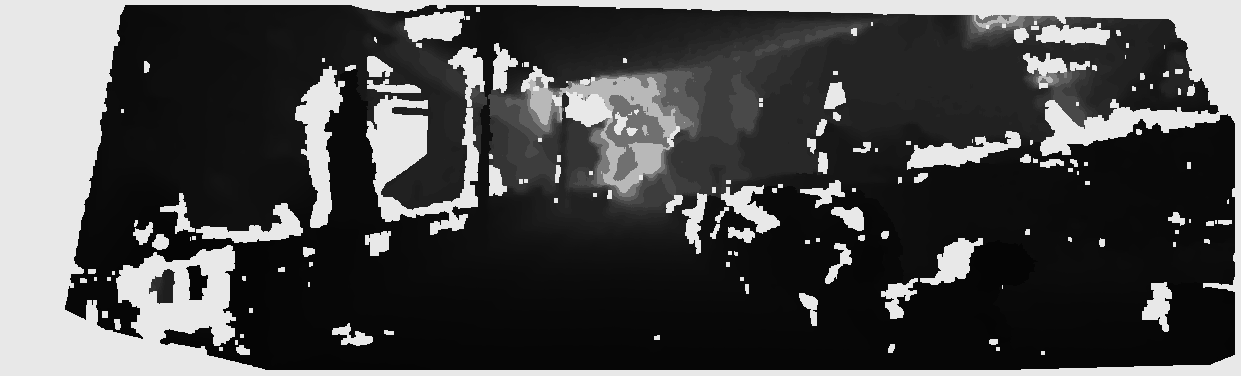

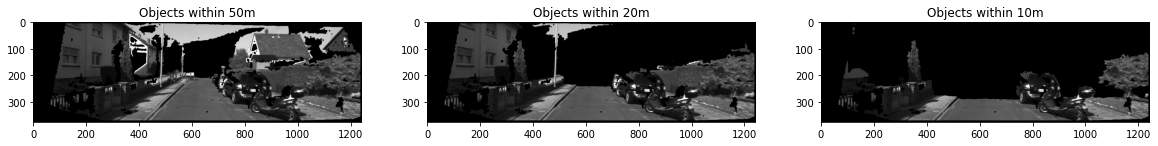

In [ ]:
#TO DO:
#(1) compute depth map from disparity map using the formula: depth = (focalLength * baseline)/disparity
#(2) use the depth map to show only object within 10m/20m/50m (Tip: apply depth threshold for each pixel)

def compute_depth(disparity):
    disparity = disparity.astype(np.float32)
    disparity[disparity <= 0.0] = 0.1
    depth = (focalLength * baseline) / disparity
    return depth

#objects within 50m
#...

#objects within 20m
#...

#objects within 10m
#...


#display results
#...

### Bonus: 3D pointcloud from disparity

In [ ]:
#TO DO: (1) using the precomputed depth map, compute 3D point coordinates